# DSCI 100 - Group Project Final Report

**Group 008-1: Jason Kim, Sam Lui, Jarod Paulson, & Sen Wang**

## Introduction

This project involved using data about how people play video games to answer one of three broad questions proposed by a research group in Computer Science at UBC that collected the data from a Minecraft server they operate. Our research question was as follows: we wanted to determine whether a given player’s total play time could be predicted using one or more variables in the provided data. This question corresponds to the first question proposed by the research group, who want to know the “kinds” of players most likely to contribute a large amount of data in order to orient their recruiting efforts towards these players. The predictive model called for by our research question will facilitate determination of whether a specific profile exists for those players that contribute the most data, which can be leveraged by the research group for subsequent recruiting efforts.

The provided dataset consisted of two comma-separated values files which are described below:

There are 196 observations and 9 variables in “players.csv":
| Variable | Type (General; Data Type in R) | Meaning |
| :- | -: | :-: |
| experience | categorical, ordinal; character | a player’s self-reported experience with Minecraft
| subscribe | categorical, nominal; logical | whether a player has subscribed to PlaiCraft’s email updates
| hashedEmail | | categorical, nominal; character |  an encoded user email
| played_hours | quantitative, continuous; double | the total number of hours played by a given player
| name | categorical, nominal; character | pseudonym selected by player to use while playing
| gender | categorical, nominal; character | a player’s self-reported gender
| age | quantitative, discrete; double | a player’s self-reported age
| individualId | NA | unclear variable type and meaning because no values exist 
| organizationName | NA | unclear variable type and meaning because no values exist 


There are 1535 observations and 5 variables in “sessions.csv”:
| Variable | Type (General; Data Type in R)| Meaning |
| :- | -: | :-: |
| hashedEmail | same as in “players.csv”
| start_time | quantitative, continuous; double | the actual start time of a Minecraft play session
| end_time | quantitative, continuous; double | the actual end time of a play session
| original_start_time | quantitative, continuous; double | the “scheduled” start time of a session in UNIX timestamp format  which is the number of seconds since January 1, 1970 (UTC)
| original_end_time | quantitative, continuous; double | the “scheduled” end time of a session in UNIX format

## Methods and Results

Considering our research question, the played_hours variable was a natural fit as the response variable for our planned predictive model. Age and experience were selected as predictor variables given their ostensible relationship with a given player’s total play time. We also considered including gender, however, aside from determining that male participants made up the highest player counts across all genders, nothing else of significance was noted.

We chose not to use sessions.csv for several reasons. 
1. There was much complexity in wrangling the data to calculate each individual sessions' duration, as it would’ve required taking into account the change in dates if session play time was spread across two days. We were then advised to calculate the individual session play time (original_end_time - original_start_time). However, the results of this process yielded nonsensical values (either 0s, ~2778 hours, or ~5556 hours) that also did not align with the session play time if we assessed this using start_time and end_time.
2. The dataset itself did not contain any meaningful variables that would be of use to recruiters in narrowing down their target demographic for their research.

### Wrangling Methodology

First, we loaded in the proper libraries required to perform the data analysis, and read in the data from their respective URLs.

As mentioned, we found the data from sessions.csv to be unconducive towards our analysis. Therefore, we used players.csv used, and selected for specific variables that were deemed important for our analysis (I.e., age, experience). 

In [7]:
library(tidyverse)
library(tidymodels)
library(RColorBrewer)
#loading the libraries needed for data wrangling, predictive work and visualizations

players_url <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
sessions_url <- "https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB"

players_data <- read_csv(players_url)

sample_players_data <- players_data |>
head()
sample_players_data

sessions_data <- read_csv(sessions_url)

sample_players_data <- sessions_data |>
head()
sample_players_data

#Reading in raw dataset (not yet manipulated), displaying first few rows of respective datasets

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,NA,NA
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,NA,NA
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA


Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


In [8]:
cleaned_players <- players_data |>
select(experience, played_hours, name, age, gender)

sample_cleaned <- cleaned_players |>
head()

sample_cleaned
#Filtered data in accordance with variables to be explored, ignored individualID and organizationName as both variables contained all NULL values, displays first few rows of respective tibble

experience,played_hours,name,age,gender
<chr>,<dbl>,<chr>,<dbl>,<chr>
Pro,30.3,Morgan,9,Male
Veteran,3.8,Christian,17,Male
Veteran,0.0,Blake,17,Male
Amateur,0.7,Flora,21,Female
Regular,0.1,Kylie,21,Male
Amateur,0.0,Adrian,17,Female


experience,total_played_hours
<fct>,<dbl>
Veteran,0.6479167
Pro,2.6000000
Regular,18.2083333
Amateur,6.0174603
Beginner,1.2485714


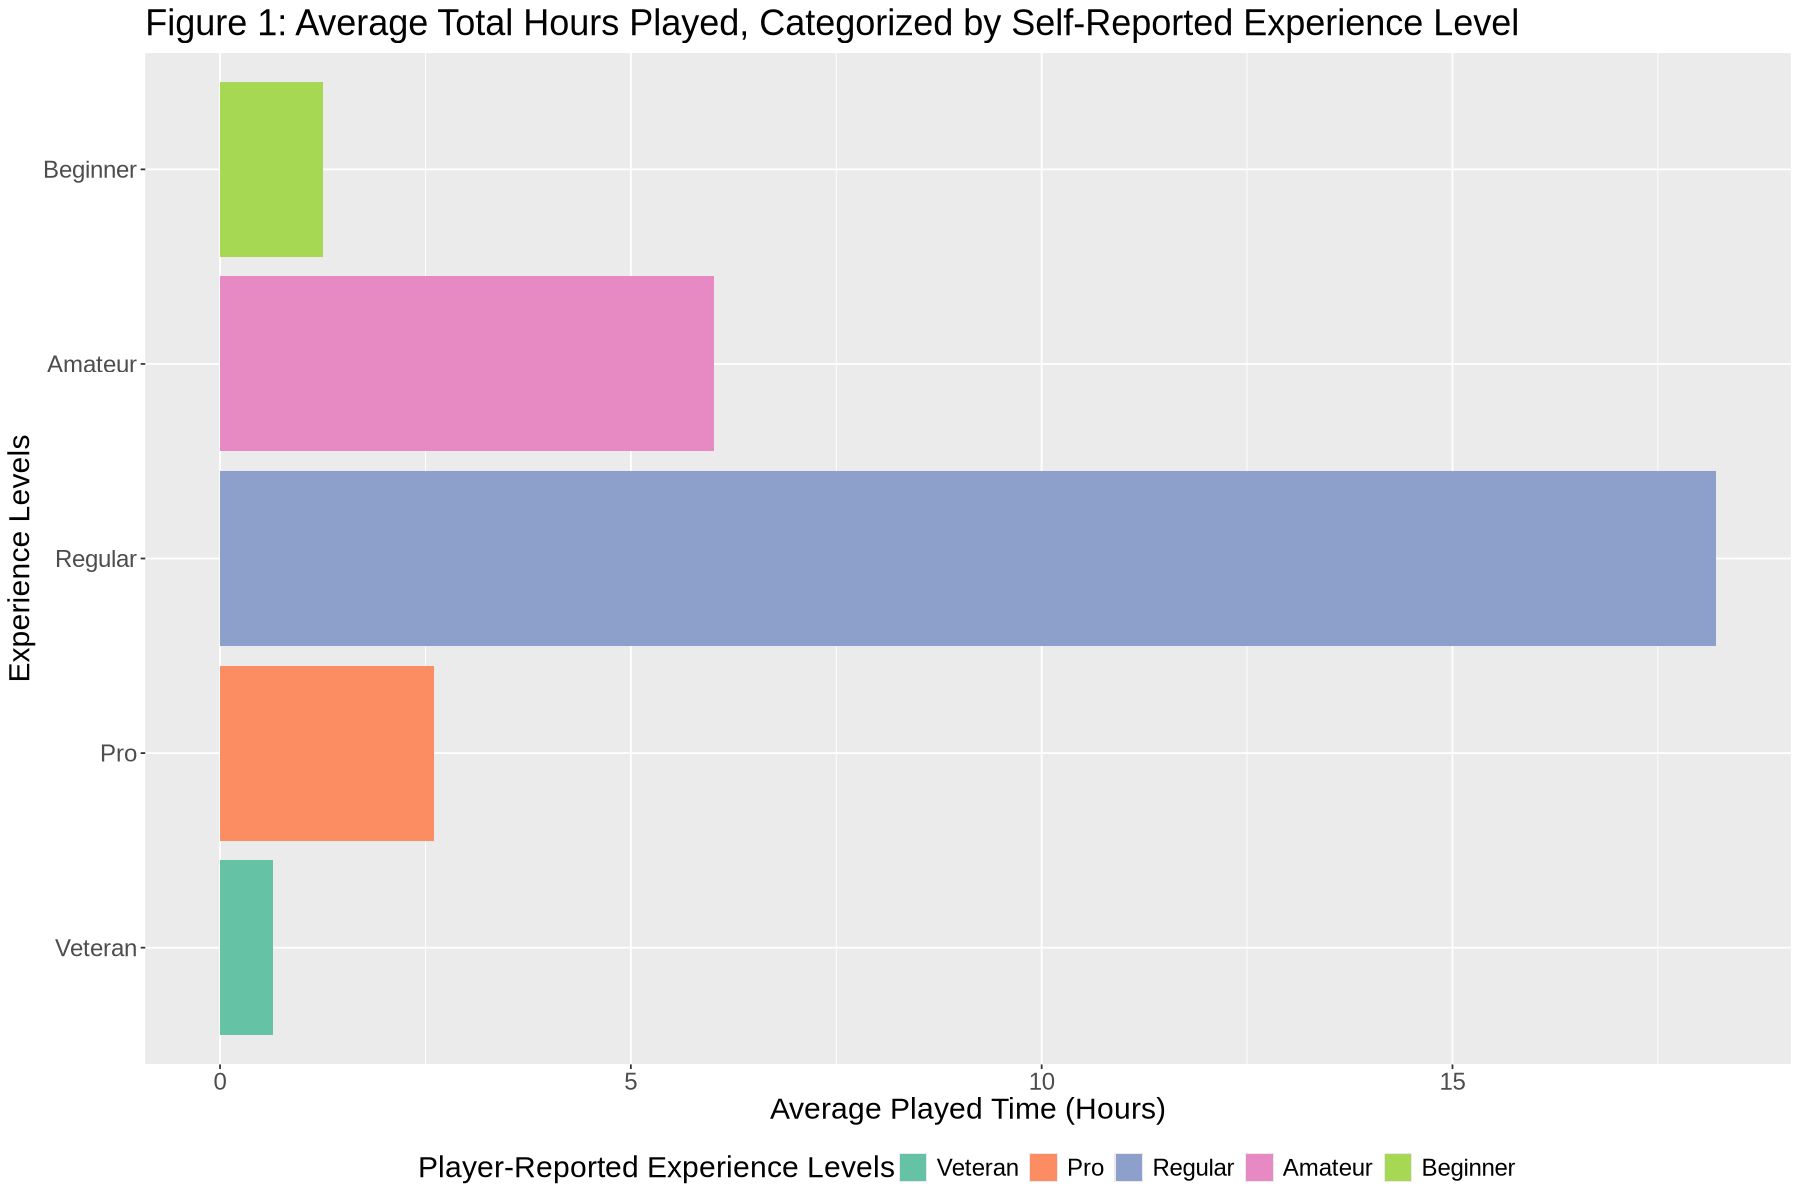

In [9]:
exp_total_hours <- cleaned_players |>
select(experience, played_hours) |>
mutate(experience = factor(experience, levels = c("Veteran", "Pro", "Regular", "Amateur", "Beginner"))) |>
group_by(experience) |>
summarize(total_played_hours = mean(played_hours))
exp_total_hours
#Created a tibble that calculates the average played hours, based on Experience classification

options(repr.plot.width = 15, repr.plot.height = 10)
exp_hours_plot <- exp_total_hours |>
ggplot(aes(x = total_played_hours, y = experience, fill = experience)) + 
geom_bar(stat = "identity") +
labs(x = "Average Played Time (Hours)", 
     y = "Experience Levels", 
     title = "Figure 1: Average Total Hours Played, Categorized by Self-Reported Experience Level",
     fill = "Player-Reported Experience Levels") +
scale_fill_brewer(palette = "Set2") +
theme(text = element_text(size = 18),
     legend.position = "bottom")
exp_hours_plot

We assessed the average number of PLAIcraft hours played, grouped by self-reported experience. **Figure 1** shows that “Regular” players played 18.2 hours on average, followed by “Amateur” players. Surprisingly, “Pro” and “Veteran” players played the least (2.6 and 0.64 hours, respectively). This was unexpected, since we initially hypothesized that high-ranking players would play more hours. However, several variables were self-reported at the start of game registration. With self-reporting, it is possible that players may have underreported their own experience levels, due to a lack of standardized classification criteria. 


age,played_hours,experience
<dbl>,<dbl>,<chr>
17,223.1,Regular
20,218.1,Regular
19,178.2,Regular
16,150.0,Amateur
23,56.1,Amateur
17,53.9,Amateur


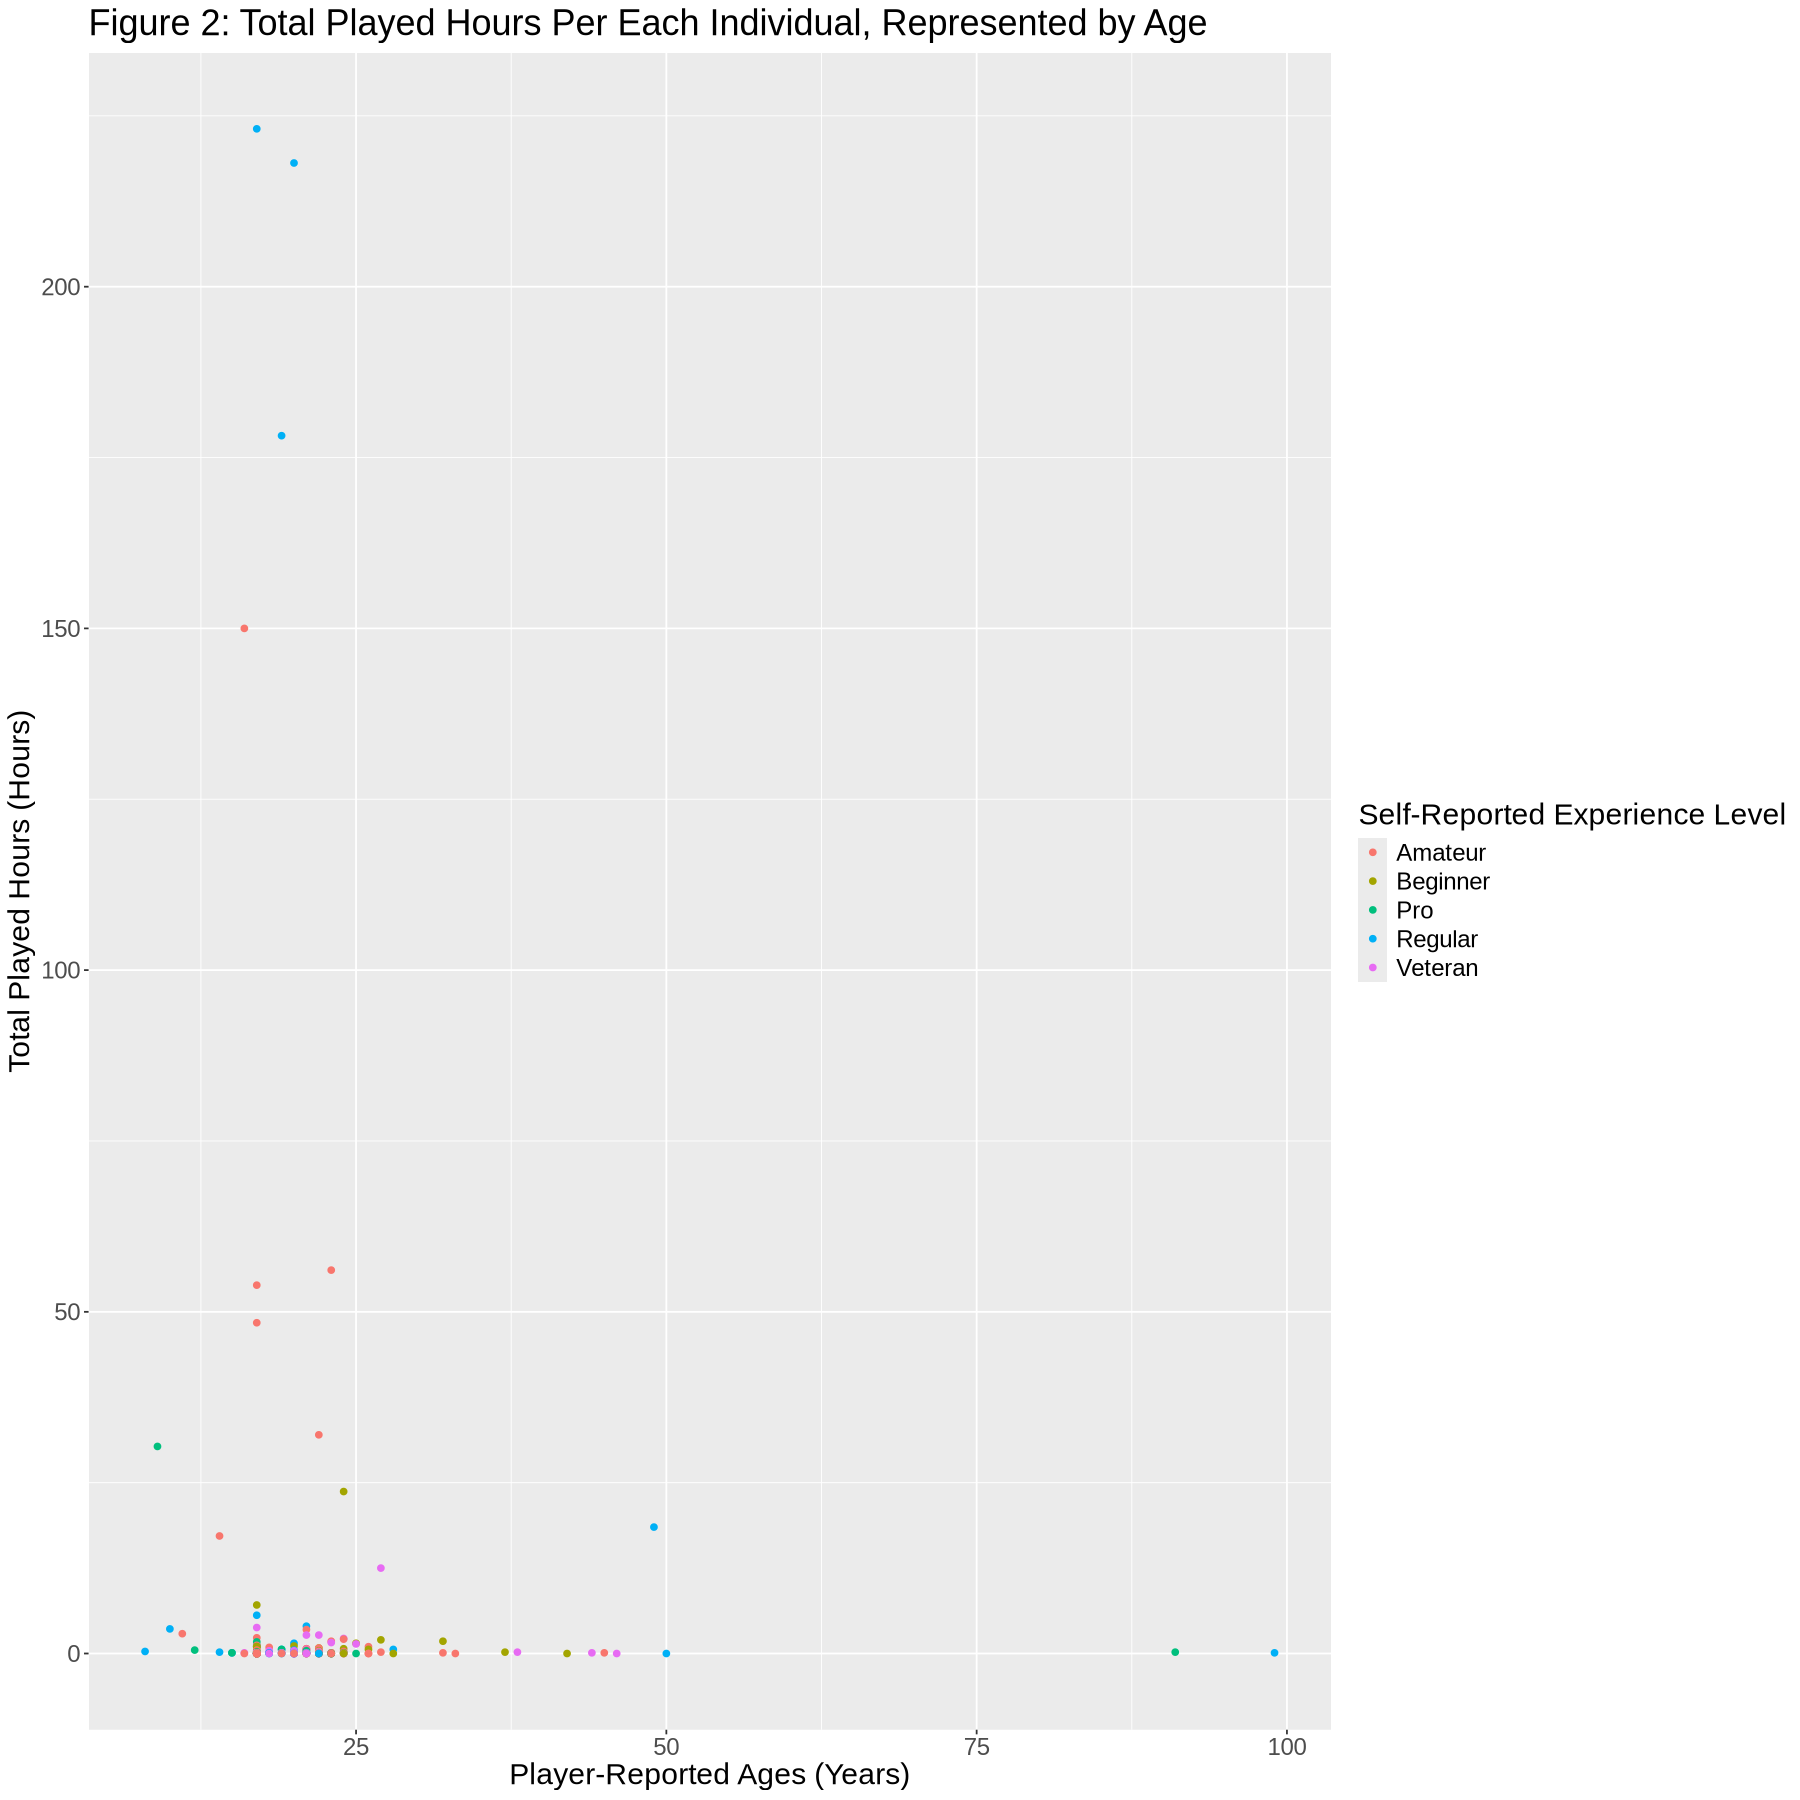

In [35]:
hours_per_age <- cleaned_players |>
select(age, played_hours, experience) |>
arrange(by = desc(played_hours))

sample_hpa <- hours_per_age |>
head()
sample_hpa
#Produced a sample tibble of of age and played_hours from cleaned_players, all records of each player noted here

options(repr.plot.width = 15, repr.plot.height = 15)
new_age_plot <- hours_per_age |>
ggplot(aes(x = age, y = played_hours, color = experience)) +
geom_point() + 
labs(x = "Player-Reported Ages (Years)", 
     y = "Total Played Hours (Hours)", 
     title = "Figure 2: Total Played Hours Per Each Individual, Represented by Age", 
    color = "Self-Reported Experience Level") +
scale_y_continuous() + 
theme(text = element_text(size = 18))
new_age_plot
#Plotted the played hours for EACH player -> Each "dot" corresponds to the players' individual age, separated by their Experience

We also examined the relationship between age and total played hours for each registered player, color-coded by self-reported experience levels. **Figure 2** shows that the current recruited players age’ ranged between 8 to 99 years old. Given this wide age range, it is believed certain reported observations for age were likely attributed to self-reporting errors at the time of registration - due to the possibility of outliers affecting the analysis, they should be removed in further downstream manipulations. However, this corroborates with findings from **Figure 1**, where Regular-ranking players clocked in the highest number of hours (See the light-blue datapoints plotted above 200 hours).

In [36]:
highest_play_ages <- cleaned_players |>
group_by(age) |>
summarize(average_played_hours = mean(played_hours)) |>
arrange(by=desc(average_played_hours)) |>
slice(1:5)
#Produces a tibble that displays the top 5 player-reported ages that have the highest hours played

highest_play_ages
#Verifies finding through scatterplot: 16 y.o.'s play the most hours

age,average_played_hours
<dbl>,<dbl>
16,50.03333
9,30.30000
19,25.65714
49,18.50000
20,15.82857


hrough further exploration and wrangling of the data utilizing group_by for age to calculate the average played hours, 16-year-olds played the highest average number of hours. This was not surprising: younger populations likely have more leisure time to play video games in comparison to an older population. Furthermore, those within university enrollment ages had high average playtime hours as well, likely attributed to the research groups’ recruitment strategies aimed at targeting an audience within close proximity. However, generally, there does not appear to be any association between average played hours with age.


[1] "Pro"      "Veteran"  "Amateur"  "Regular"  "Beginner"

experience,played_hours,name,age,gender,experience_num
<fct>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
Pro,30.3,Morgan,9,Male,5
Veteran,3.8,Christian,17,Male,4
Veteran,0.0,Blake,17,Male,4
Amateur,0.7,Flora,21,Female,2
Regular,0.1,Kylie,21,Male,3
Amateur,0.0,Adrian,17,Female,2


Warning message:
“Removed 14 rows containing missing values or values outside the scale range
(`geom_point()`).”


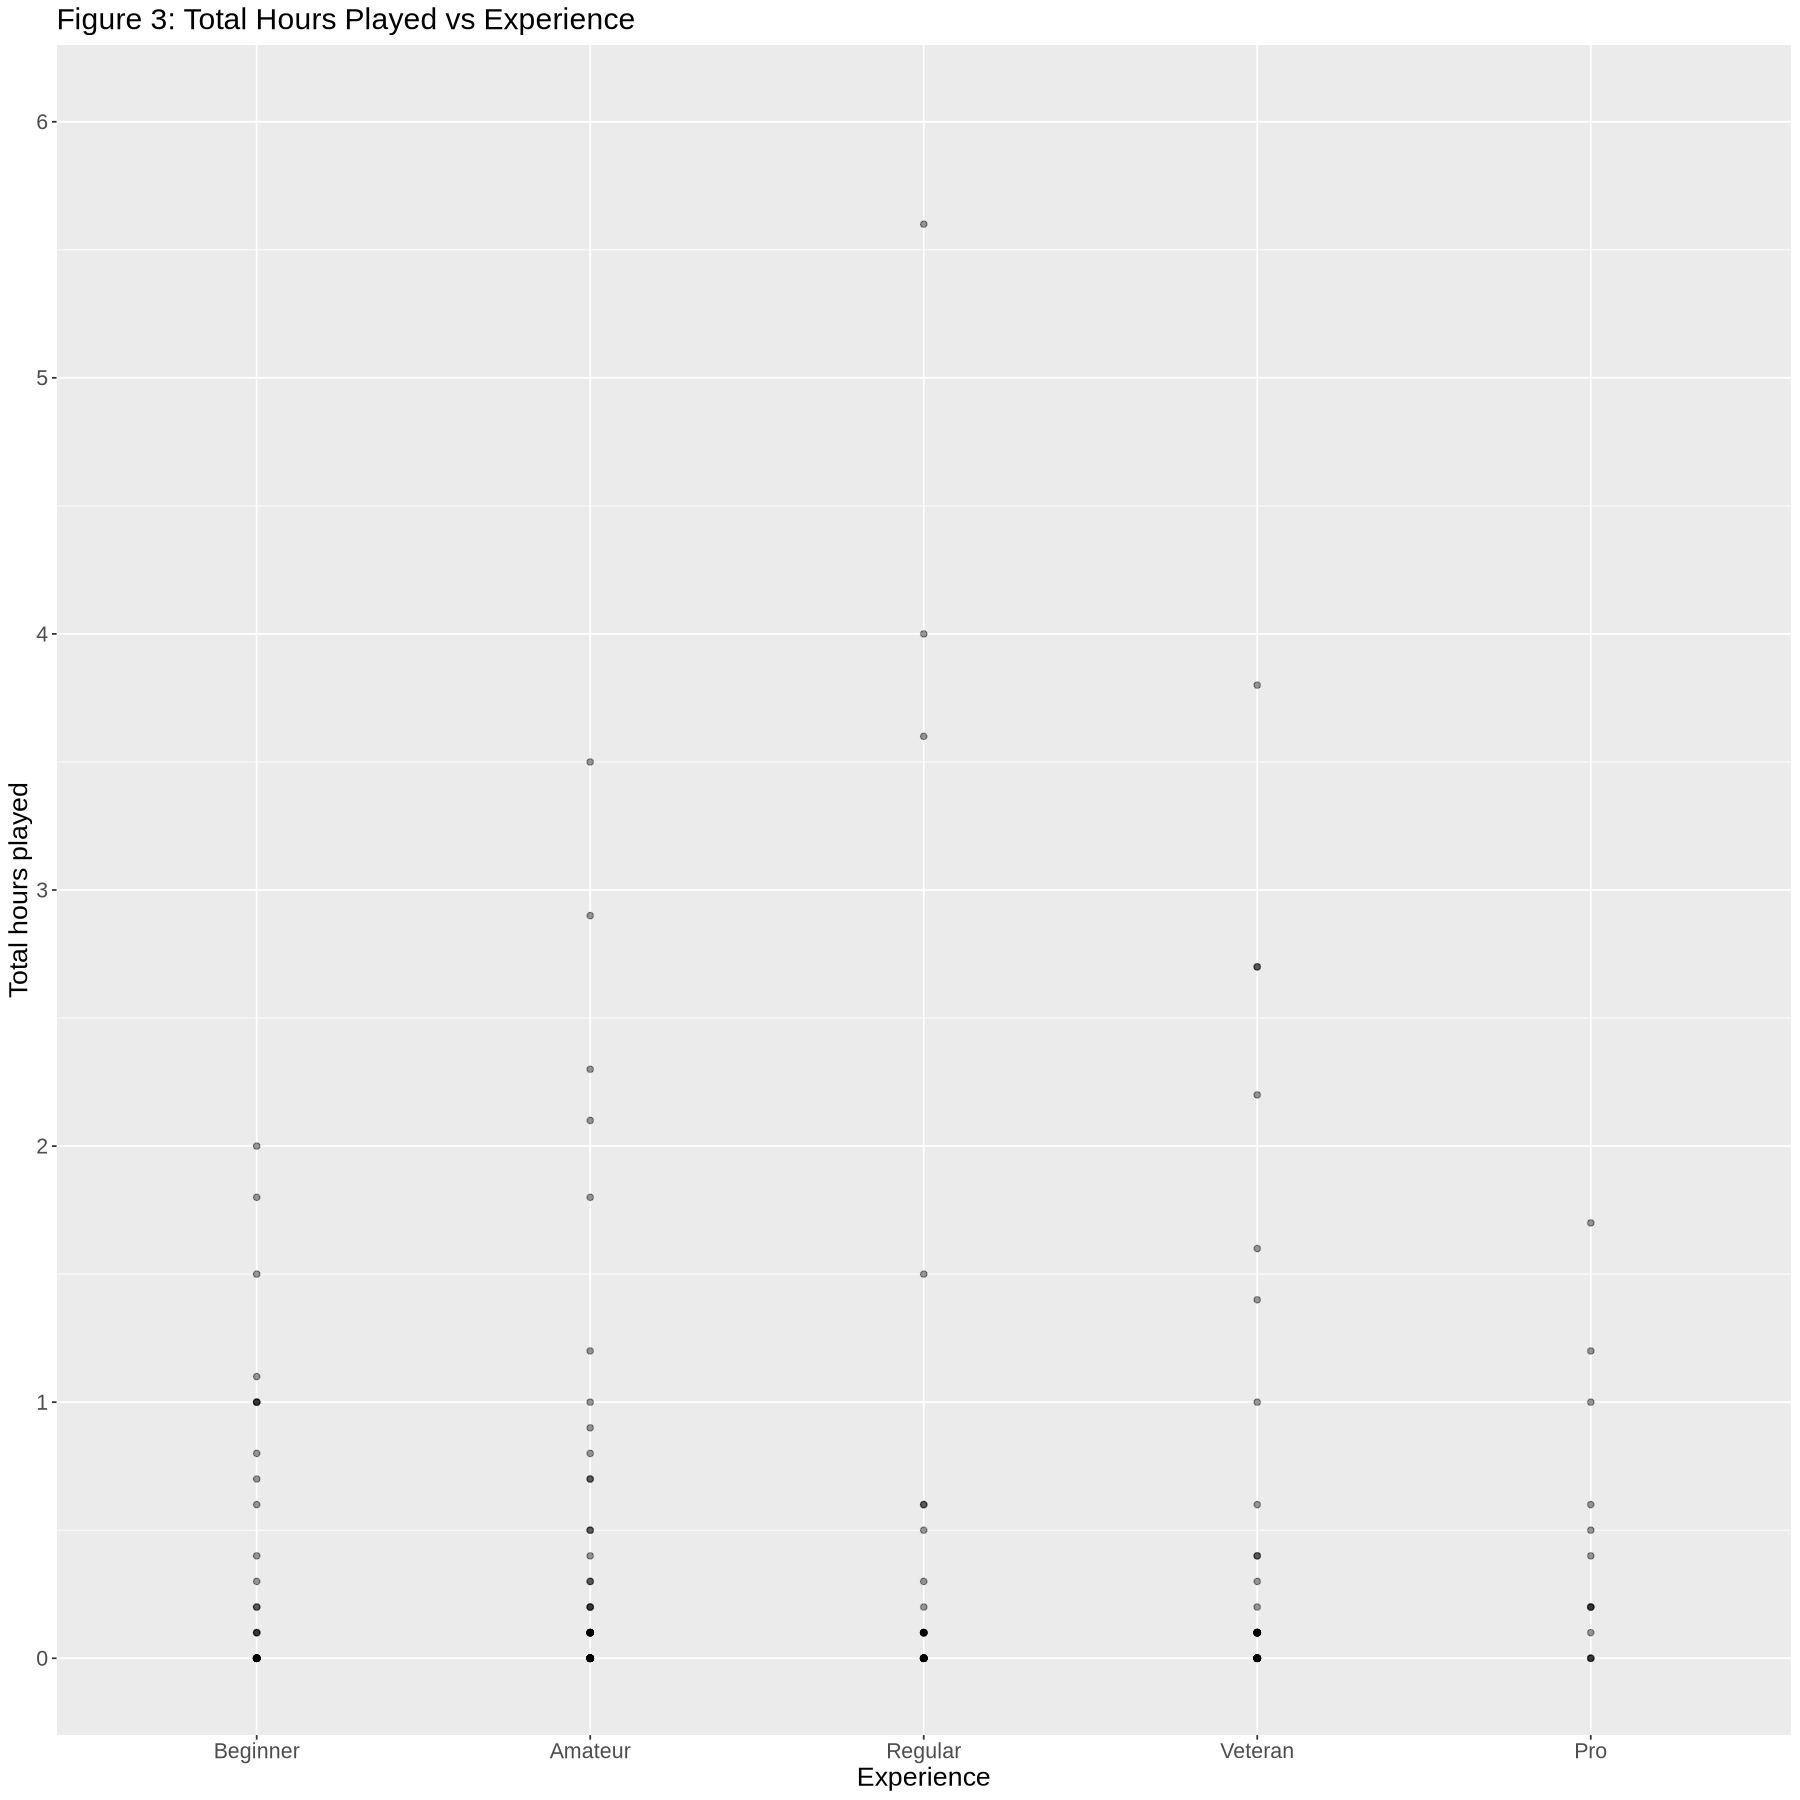

In [12]:
# Transform Experience INTO a factor - Generate factor variable for experience level -> Code taken from Jason's individual report
unique(cleaned_players$experience)
experience_levels <- c("Beginner", "Amateur", "Regular", "Veteran", "Pro")

transformed_players <- cleaned_players |>
    mutate(experience = factor(experience, levels = experience_levels), # factor variable           
          experience_num = case_when(experience == "Beginner" ~ 1,      # numeric variable for use in 
                                     experience == "Amateur" ~ 2,       #  regression in final report
                                     experience == "Regular" ~ 3,
                                     experience == "Veteran" ~ 4,
                                     experience == "Pro" ~ 5))

sample_transformed <- transformed_players |>
head()
sample_transformed

players_expnum_plot <- ggplot(transformed_players, aes(x = experience, y = played_hours)) +
        geom_point(alpha = 0.4) +
        labs(x = "Experience", y = "Total hours played", title = "Figure 3: Total Hours Played vs Experience") +
        scale_y_continuous(name = "Total hours played", limits = c(0, 6), breaks = seq(0, 6, by = 1)) +
        theme(text = element_text(size=16),
             plot.title = element_text(size=18))
players_expnum_plot
#Used Jason's plot from his report
#Likely just a confirmation that Regular players still played the most outside of all Experience levels
#Also means that the research group should not be targetting "Pro" players

From preliminary investigations, it was noted that experience and age may have the most profound impacts on total play time. So, we transformed experience into a numerical type (i.e., 1 - “Beginner”, 2 - “Amateur etc.). From **Figure 3**, we explored the overall distribution of experience (as a factor) with play time. This reaffirms the findings from our bar plot, confirming that the research group should not put their recruitment efforts into recruiting “Pros” or “Veterans”, given the low number of hours played. 

## Predictive Model and Analysis

In [16]:
selected_transformed_players <- transformed_players |>
select(played_hours, age, experience_num) |>
    filter(age <= 55 & played_hours <= 6)
# Select variables of interest, remove outliers


sample_selected_transformed_players <- selected_transformed_players |>
head()
sample_selected_transformed_players

played_hours,age,experience_num
<dbl>,<dbl>,<dbl>
3.8,17,4
0.0,17,4
0.7,21,2
0.1,21,3
0.0,17,2
0.0,19,3


### Overview of the approach

In this section, we perform a K-NN regression given that the relationship is non-linear between age and played hours, and between experience and played hours. We split the data and tune our model on the 
training set using cross-validation. As part of the model tuning process, we use forward selection by first training a model using only age as the predictor, and then training a multivariable model using both age and experience level as predictors. After determining a model with optimal K and selection of predictors, we evaluate our predictive model on the testing set.

### Splitting the data

First, we split the players data into training and testing sets using a 70/30 split.

In [18]:
#### K-NN Regression ####

## Model 1: Predicting played hours based on age ##

# set seed
set.seed(234)

# set plot dimensions
options(repr.plot.width = 7, repr.plot.height = 7)

# split the data: 70 training / 30 testing
players_split <- initial_split(selected_transformed_players, prop = 0.70, strata = played_hours)
players_training <- training(players_split)
players_testing <- testing(players_split)

### Cross-validation

We perform a cross-validation to choose an optimal number of neighbours K. First, we create the model specification for tuning our K-NN regression model. Next, we construct the model recipe using played hours as the response variable and age as the predictor variable, with scaled and centered age. We construct a workflow using the recipe and model specification.

In [19]:
# Create model specification
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

# Recipe
players_recipe <- recipe(played_hours ~ age, data = selected_transformed_players) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Construct workflow
players_workflow <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec)

players_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


We consider the size of the training set when choosing the number of cross-validation folds. Given the relatively small size of the data, we take a conservative approach and choose 5 folds. We use the argument *strata = played_hours* to ensure even distributions of the response variable across the 5 folds. We compute the root mean square prediction error (RMSPE) for values of K from 1 to 9, and plot the RMSPE for each value of K.

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,0.9552977,5,0.1725776,Preprocessor1_Model1
2,rmse,standard,0.9251400,5,0.1795036,Preprocessor1_Model2
3,rmse,standard,0.8986111,5,0.1866557,Preprocessor1_Model3
4,rmse,standard,0.9220955,5,0.1856823,Preprocessor1_Model4
5,rmse,standard,0.8961893,5,0.1867441,Preprocessor1_Model5
6,rmse,standard,0.8936842,5,0.1939093,Preprocessor1_Model6
7,rmse,standard,0.8977329,5,0.1940823,Preprocessor1_Model7
8,rmse,standard,0.8807706,5,0.1817591,Preprocessor1_Model8
9,rmse,standard,0.8768492,5,0.1882020,Preprocessor1_Model9


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
9,rmse,standard,0.8768492,5,0.188202,Preprocessor1_Model9


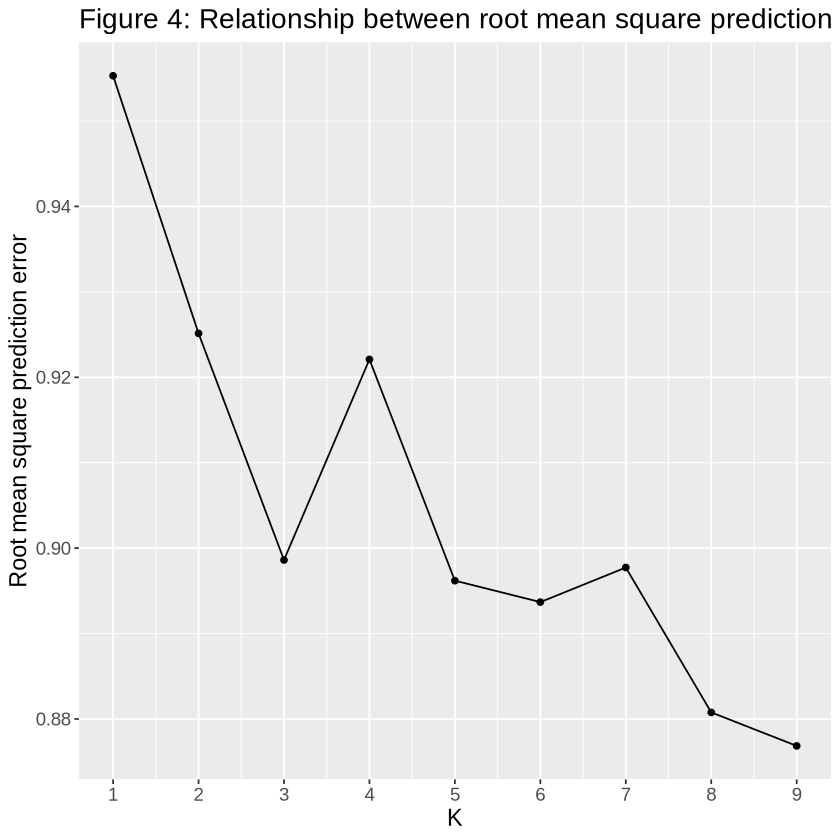

In [31]:
# Specify number of cross-validation folds
players_vfold <- vfold_cv(players_training, v = 5, strata = played_hours)

# Specify number of neighbors to compare
gridvals <- tibble(neighbors = seq(from = 1, to = 9, by = 1))

# Compute RMSPE for different values of K neighbors
players_results <- players_workflow |>
    tune_grid(resamples = players_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

players_results

rmspe <- players_results |>
    # filter(.metric == "rmse") |>
    select(neighbors, mean)

# Plot RMSPE vs K
rmspe_plot <- rmspe |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "K", 
         y = "Root mean square prediction error",
        title = "Figure 4: Relationship between root mean square prediction error and number of neighbors K") +
    theme(text = element_text(size=14)) +
    scale_x_continuous(breaks = seq(1,9, by = 1), limits = c(1,9)) 

rmspe_plot

# Extract minimum RMSPE
players_min <- players_results |>
    filter(.metric == "rmse") |>
    slice_min(order_by = mean, n = 1)

players_min

k_min <- players_min |>
    pull(neighbors)

We obtained a minimum RMSPE value of 0.93 corresponding to K = 8 **(Figure 4)**. We select K = 8 as the optimal K found by cross-validation and store it as the object k_min.

### Forward selection: adding experience level to the model

We investigate whether adding experience as a predictor improves our model (i.e., lowers the RMSPE estimated by cross-validation). We create a new recipe for a multivariable model with both age and experience as predictors, and repeat the tuning process using cross-validation.

In [26]:
## Model 2: Predicting played hours based on age and experience level ##

# Create model specification
# players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
#     set_engine("kknn") |>
#     set_mode("regression")

# Recipe
players_recipe_1 <- recipe(played_hours ~ age + experience_num, data = players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Construct workflow
players_workflow_1 <- workflow() |>
    add_recipe(players_recipe_1) |>
    add_model(players_spec)

players_workflow_1

# Specify number of cross-validation folds
# players_vfold <- vfold_cv(players_training, v = 5, strata = played_hours)

# Compute RMSPE for different values of K neighbors
# gridvals <- tibble(neighbors = seq(from = 1, to = 9, by = 1))

players_results_1 <- players_workflow_1 |>
    tune_grid(resamples = players_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

rmspe_1 <- players_results_1 |>
    # filter(.metric == "rmse") |>
    select(neighbors, mean)

# Find minimum RMSPE
players_min_1 <- players_results_1 |>
    filter(.metric == "rmse") |>
    slice_min(order_by = mean, n = 1)

players_min_1

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
9,rmse,standard,0.9469178,5,0.135498,Preprocessor1_Model9


Compared to the first model with age as the only predictor, the inclusion of experience level as a predictor results in a higher minimum RMSPE (RMSPE = 0.96 vs RMSPE = 0.93). In other words, including experience level as an additional predictor does not improve our model. Therefore, we proceed with the first model using age as the only predictor.

### Evaluating the model on the testing set

We create a new K-NN regression model specification using the optimal K that we found in our first model. We create a new workflow using our new model specification and fit a model on the entire training set. We then evaluate our final tuned model on the testing set and output the RMSPE of our predictions on the testing set. The predictions were plotted over the original data **(Figure 5)**.

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.72575360
rsq,standard,0.05532764
mae,standard,0.41878788


.pred,played_hours,age,experience_num
<dbl>,<dbl>,<dbl>,<dbl>
0.02222222,0.0,17,4
0.50000000,0.1,21,3
0.50000000,0.0,21,2
0.02222222,0.1,17,2
0.15555556,0.0,22,4
0.02222222,0.0,17,5


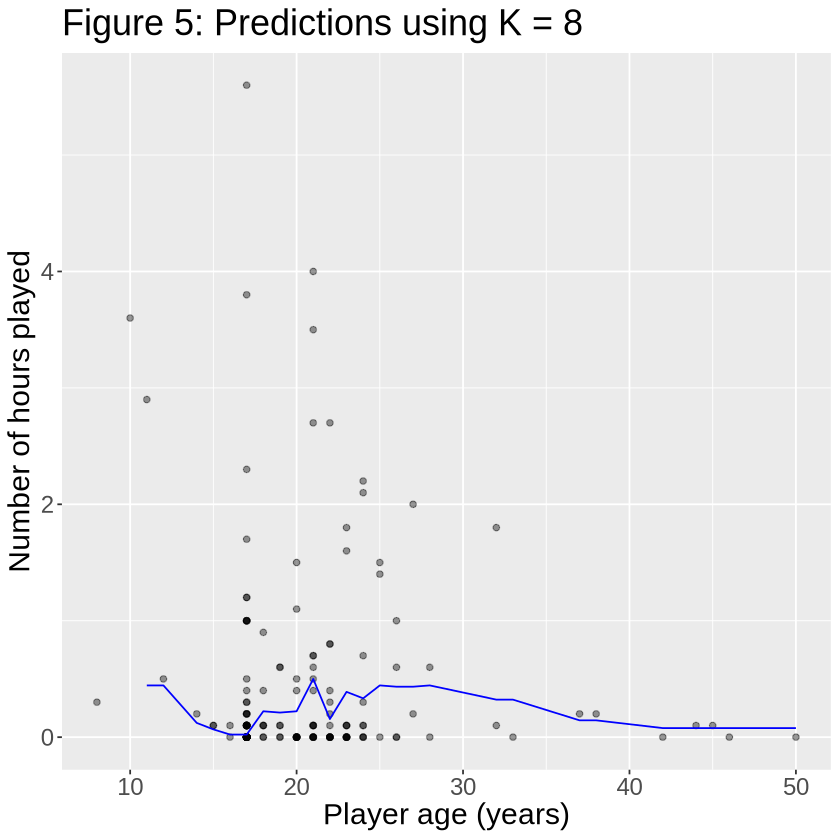

In [30]:
# Create model specification using optimal K
players_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
    set_engine("kknn") |>
    set_mode("regression")

# Create new workflow using best spec and fit on training set
players_best_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_best_spec) |>
    fit(data = players_training)

# Evaluate tuned model on the testing set
players_results <- players_best_fit |>
    predict(players_testing) |>
    bind_cols(players_testing) |>
    metrics(truth = played_hours, estimate =.pred)

players_results

# Plot predictions over the original players data
players_preds <- players_best_fit |>
    predict(players_training) |>
    bind_cols(players_training)

head(players_preds)

players_plot <- ggplot(data = selected_transformed_players, aes(x = age, y = played_hours)) +
    geom_point(alpha = 0.4) +
    geom_line(data = players_preds, 
              mapping = aes(x = age, y = .pred),
              color = "blue") + 
    xlab("Player age (years)") +
    ylab("Number of hours played") +
    ggtitle("Figure 5: Predictions using K = 8") +
    # ggtitle(paste0("Figure Y: Predictions using K = ", k_min)) +
    theme(text = element_text(size = 18))

players_plot

We obtained an RMSPE of 0.72 on the testing set. This can be interpreted as: the predictions on the test data given by our model have an error of approximately +/- 0.72 hours on average. Whether an RMSPE value is “good” depends on the problem. In the context of our research question, Plaicraft is looking for individuals who are more likely to contribute time and game data. A prediction error of around 43 minutes may be considered high, especially given that the majority of registered players contribute less than 1 hour of playing time (75th percentile = 0.6 played hours). Therefore, age may not be considered an accurate predictor of game play hours using the Plaicraft data.

## Discussion

## References

1. Timbers, T., Trevor, C., & Lee, M. (2024). Data Science. https://datasciencebook.ca/